# **Interactive structure/property explorer for materials and molecules**

## **Lecturer: Prof. Arghya Bhowmik (arbh@dtu.dk)**

The notebook demonstrate how use fixed fingerprints like SOAP or the descripoter from foundation model can be used to visualize the chemical space in a interactive web interface using the beautiful tool [Chemiscope](https://chemiscope.org/docs/)



1. Chemiscope Documentation: [Chemiscope Org](https://chemiscope.org/docs/)
2. Dscribe: Atomic structure to fixed finger prints [dscribe](https://singroup.github.io/dscribe/latest/)
3. MACE foundation models [MACE0](https://github.com/ACEsuit/mace-foundations)

The notebook prepared by: Chiku Parida (chipa@dtu.dk), Diptendu Roy (dpro@dtu.dk)

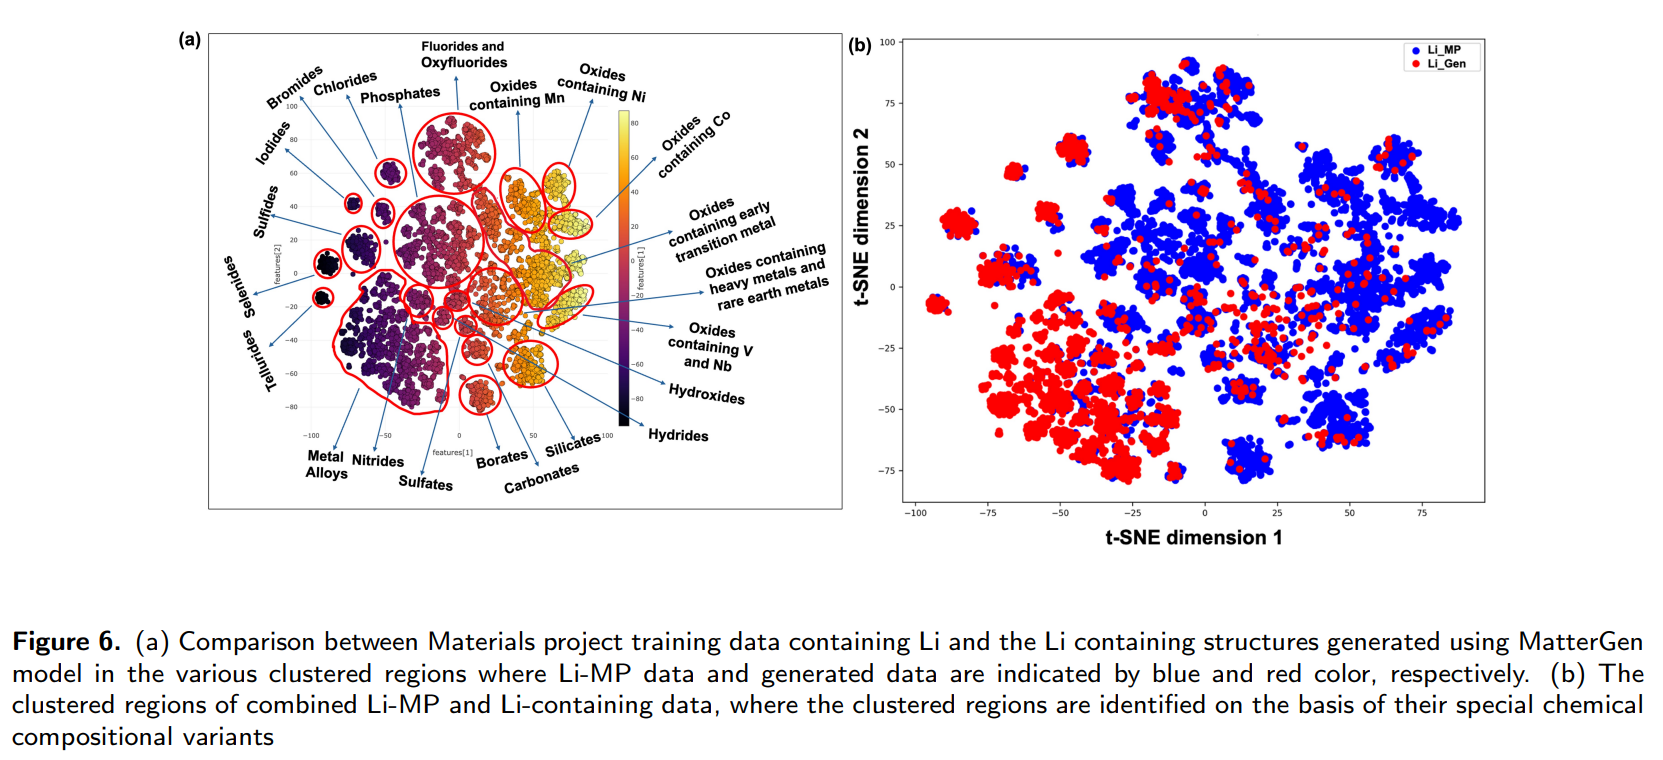


Ref: [Mining Chemical Space with Generative Models for Battery Materials](https://chemrxiv.org/engage/chemrxiv/article-details/68093169927d1c2e666f1055)









## Lets prepare the environment and isntall the required packages (chemiscope, dscribe and MACE)

In [ ]:
!pip install chemiscope
!pip install dscribe
!pip install mace

## Let's load our crystal dataset and visualize them..!
**Note:** Download the dataset from the github repo, load and visulize using Atomic Simulation Environment. You are welcome to use your own data.



In [ ]:
from ase.io import read, write
from ase.visualize import view

atoms = read('dataset.traj')
view(atoms)

## Now we will featurize and visualize the chemical space of our data dataste with SOAP descriptors

In [ ]:
# import the required modules
import time
from ase.io import read
from sklearn.manifold import TSNE
import chemiscope
import numpy as np
import os
from dscribe.descriptors import SOAP
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Start timing
start_time = time.time()

# Load dataset
a = read('Li_MP_data.db', index=':')

def soap_tnse_with_environments(frames, environments):
    if environments is None:
        raise ValueError("'environments' must be provided")

    grouped_envs = {}
    unique_structures = set()

    # Get atom-centered indices from environments
    for [env_index, atom_index, _cutoff] in environments:
        if env_index not in grouped_envs:
            grouped_envs[env_index] = []
        grouped_envs[env_index].append(atom_index)
        unique_structures.add(env_index)
    centers = list(grouped_envs.values())

    # only include frames that are present in the environments
    if len(unique_structures) != len(frames):
        frames = [frames[index] for index in sorted(unique_structures)]

    # Get global species
    species = set()
    for frame in frames:
        species.update(frame.get_chemical_symbols())
    species = list(species)

    # Initialize calculator
    soap = SOAP(
        species=species,
        r_cut=4.5,
        n_max=8,
        l_max=6,
        sigma=0.2,
        rbf="gto",
        average="outer",
        periodic=True,
        weighting={"function": "pow", "c": 1, "m": 5, "d": 1, "r0": 3.5},
        compression={"mode": "mu1nu1"},
    )

    # Calculate descriptors
    feats = soap.create(frames, centers=centers)

    # Compute tsne
    perplexity = min(50, feats.shape[0] - 1)
    reducer = TSNE(n_components=2, perplexity=perplexity)
    return reducer.fit_transform(feats)

cs = chemiscope.explore(
    frames=a,
    featurize=soap_tnse_with_environments,
    environments=chemiscope.all_atomic_environments(a),
)

cs.save("SOAP_data.html")

# End timing
end_time = time.time()
elapsed = end_time - start_time
print(f"\n Done! Total time: {elapsed:.2f} seconds.")

## Now we will featurize and visualize the chemical space of our data dataste with MACE descriptors

The below code block can load the small MACE foundation model and the extracted descriptors from the neural network is used for visualization using chemical space. You can copy the code block and call the medium and large MACE foundation model for feturization. Check if you are getting any noticable differences.



```
# change the model value for loading medium or large model
descriptor_opt = {"model": "small", "device": "cpu", "default_dtype": "float64"}
```



In [ ]:
# Load the required modules
import time
from ase.io import read
from sklearn.manifold import TSNE
import chemiscope
import numpy as np
import os
from mace.calculators.foundations_models import mace_mp
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Start timing
start_time = time.time()

# Load dataset
a = read('Li_MP_data.db', index=':')

def mace_mp0_tsne(frames, environments):
    if environments is not None:
        raise ValueError("'environments' are not supported by this featurizer")

    # Initialise a mace-mp0 calculator
    descriptor_opt = {"model": "small", "device": "cpu", "default_dtype": "float64"}
    calculator = mace_mp(**descriptor_opt)

    def compute_descriptor(frame):
        desc = calculator.get_descriptors(frame, invariants_only=True)
        return np.mean(desc, axis=0)

    # Parallel descriptor calculation
    n_jobs = min(len(frames), os.cpu_count())
    descriptors = []

    with ThreadPoolExecutor(max_workers=n_jobs) as executor:
        futures = [executor.submit(compute_descriptor, frame) for frame in frames]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Extracting descriptors"):
            descriptors.append(future.result())

    descriptors = np.array(descriptors)

    if descriptors.shape[0] <= 1:
        raise ValueError("Need at least two structures for t-SNE.")

    # Apply t-SNE
    perplexity = min(50, descriptors.shape[0] - 1)
    reducer = TSNE(n_components=2, perplexity=perplexity, n_jobs=n_jobs, random_state=42)
    return reducer.fit_transform(descriptors)

cs = chemiscope.explore(a, featurize=mace_mp0_tsne)
cs.save("li_MP_data.html")

# End timing
end_time = time.time()
elapsed = end_time - start_time
print(f"\n Done! Total time: {elapsed:.2f} seconds.")